In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("real_estate_casa.xlsx")

In [3]:
df_unique = df.drop_duplicates(subset=["Name", "Location", "Price"], keep="first")

In [4]:
df_duplicates = df[df.duplicated(subset=["Name", "Location", "Price"], keep="first")]

In [48]:
df_unique.to_excel("apartments_clean.xlsx", index=False)

In [49]:
print("Unique apartments:", df_unique.shape[0])
print("Duplicates removed:", df_duplicates.shape[0])

Unique apartments: 4598
Duplicates removed: 421


In [56]:
import pandas as pd

df = pd.read_excel("apartments_clean.xlsx")
print(df.head())
print(df.info())
print(df.isna().sum())

                                          Name  \
0      Appartement à vendre 50 m² à Casablanca   
1     Grand appartement à vendre sur Bernoussi   
2  Studios de Standing à 5 min du Morocco Mall   
3                               Le panoramique   
4     A Vendre Appartement 150m² cité des arts   

                                Location         Price  Superficy  Rooms  
0  Ahl Loghlam (Hay Assalam), Casablanca    360 000 DH       51.0    4.0  
1                    Al Qods, Casablanca    695 000 DH      110.0    5.0  
2                      Almaz, Casablanca    650 000 DH       48.0    2.0  
3                       Anfa, Casablanca  2 500 000 DH      169.0    4.0  
4              Bourgogne Est, Casablanca  2 300 000 DH      150.0    6.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598 entries, 0 to 4597
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4597 non-null   object 
 1   Location   4597 no

In [57]:
# Remove spaces and "DH", keep only digits
df["Price"] = df["Price"].astype(str).str.replace(r"[^\d]", "", regex=True)

# Convert to numeric
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Check how many numeric rows we have now
print("Rows with numeric Price:", df["Price"].notna().sum())

# Keep only rows with numeric Price for plotting
df_plot = df.dropna(subset=["Price"])
print("Rows available for plotting:", df_plot.shape[0])
print(df_plot["Price"].head())

Rows with numeric Price: 4413
Rows available for plotting: 4413
0     360000.0
1     695000.0
2     650000.0
3    2500000.0
4    2300000.0
Name: Price, dtype: float64


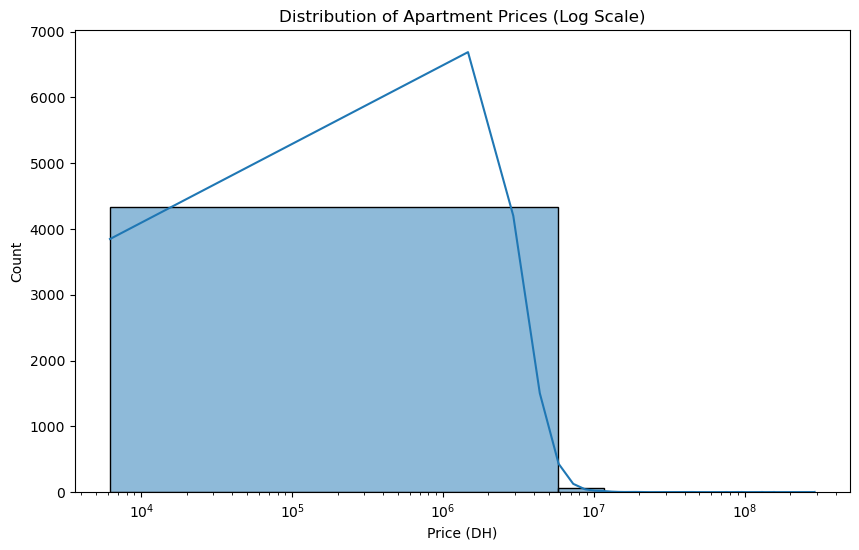

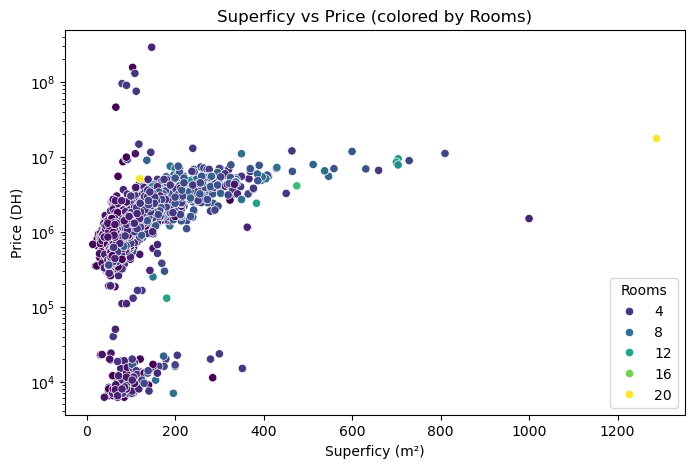

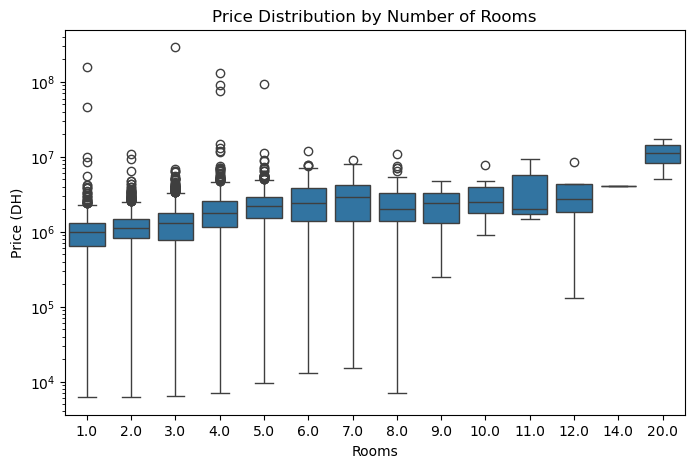

C:\Users\HP\AppData\Local\Temp\ipykernel_25184\2175566702.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.index, y=top10.values, palette="coolwarm")


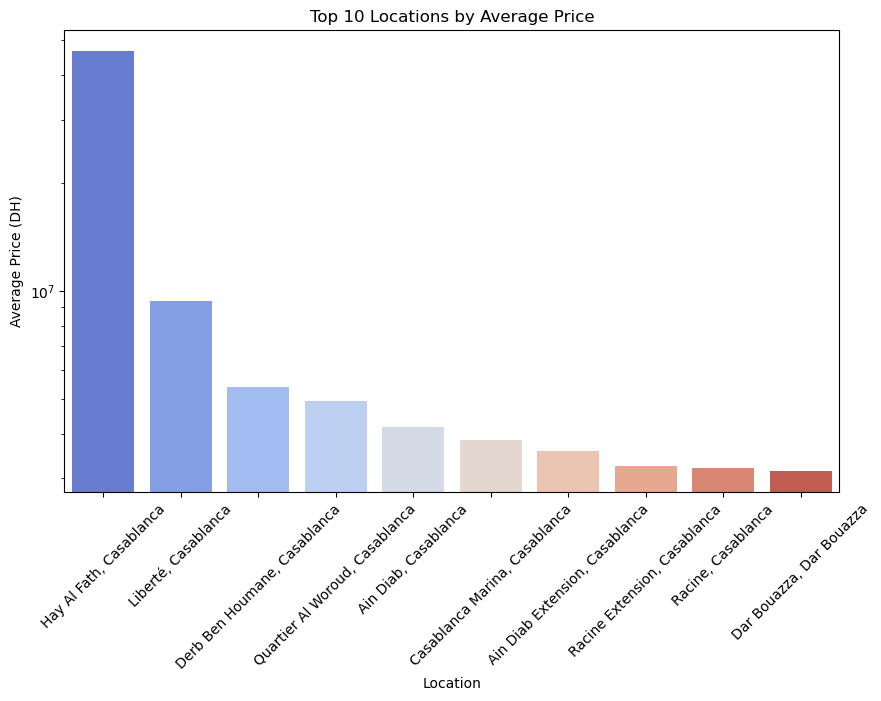

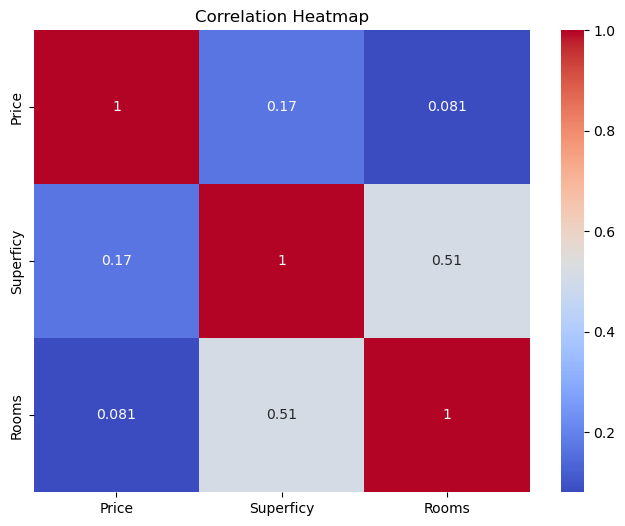

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Price distribution (histogram)
plt.figure(figsize=(10,6))
sns.histplot(df_plot["Price"], bins=50, kde=True)
plt.xscale('log')  # log scale for better visualization
plt.title("Distribution of Apartment Prices (Log Scale)")
plt.xlabel("Price (DH)")
plt.ylabel("Count")
plt.show()

# 2) Superficy vs Price (scatter)
plt.figure(figsize=(8,5))
sns.scatterplot(x="Superficy", y="Price", hue="Rooms", data=df_plot, palette="viridis")
plt.yscale('log')  # log scale for Price
plt.title("Superficy vs Price (colored by Rooms)")
plt.xlabel("Superficy (m²)")
plt.ylabel("Price (DH)")
plt.show()

# 3) Price by Rooms (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x="Rooms", y="Price", data=df_plot)
plt.yscale('log')  # log scale
plt.title("Price Distribution by Number of Rooms")
plt.ylabel("Price (DH)")
plt.show()

# 4) Average price per Location
plt.figure(figsize=(10,6))
top10 = avg_price.sort_values(ascending=False).head(10)
sns.barplot(x=top10.index, y=top10.values, palette="coolwarm")
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Average Price (DH)")
plt.title("Top 10 Locations by Average Price")
plt.show()
# 5) Correlation heatmap (no log needed)
plt.figure(figsize=(8,6))
sns.heatmap(df_plot[["Price", "Superficy", "Rooms"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


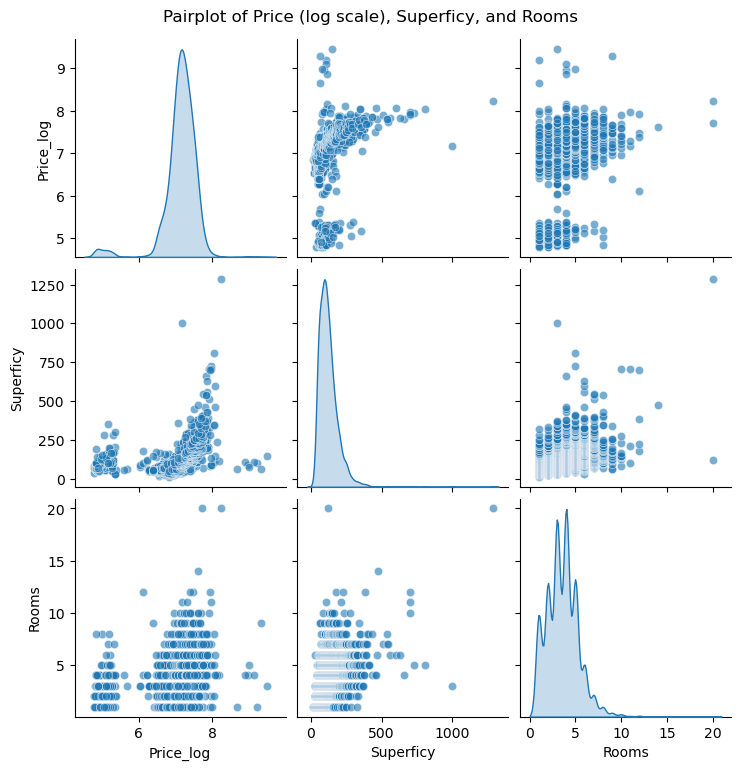

In [43]:
df_pair = df_plot[["Price", "Superficy", "Rooms"]].copy()

# Apply log scale to Price for visualization
df_pair["Price_log"] = np.log10(df_pair["Price"])

# Pairplot
sns.pairplot(
    df_pair,
    vars=["Price_log", "Superficy", "Rooms"],
    kind="scatter",
    diag_kind="kde",
    hue=None,  # or you can color by Rooms if you like: hue="Rooms"
    plot_kws={"alpha":0.6}
)

plt.suptitle("Pairplot of Price (log scale), Superficy, and Rooms", y=1.02)
plt.show()

In [108]:
import numpy as np

# Drop specific rows first
indexes_to_drop = [2987, 2599, 2763]
df_plot = df_plot.drop(index=indexes_to_drop)

# Function to cap extreme high prices per location at 95th percentile
def cap_prices(group):
    cap = group["Price"].quantile(0.95)
    group = group.copy()  # avoid SettingWithCopyWarning
    group["Price"] = np.where(group["Price"] > cap, cap, group["Price"])
    return group

# Apply capping by location
df_no_outliers = df_plot.groupby("Location", group_keys=False, as_index=False).apply(cap_prices)

# Reset index
df_no_outliers = df_no_outliers.reset_index(drop=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_25184\1473170291.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df_plot.groupby("Location", group_keys=False, as_index=False).apply(cap_prices)


In [109]:
# Create a copy to avoid modifying original
df_cleaned = df_plot.copy()

# Detect and remove extreme outliers per location
clean_list = []

for loc, group in df_cleaned.groupby("Location"):
    Q1 = group["Price"].quantile(0.25)
    Q3 = group["Price"].quantile(0.75)
    IQR = Q3 - Q1
    # Keep only values within 1.5*IQR above Q3 and below Q1
    group_clean = group[(group["Price"] <= Q3 + 1.5 * IQR) & (group["Price"] >= Q1 - 1.5 * IQR)]
    clean_list.append(group_clean)

# Combine all cleaned groups
df_no_outliers = pd.concat(clean_list)

print("Rows before removing outliers:", df_plot.shape[0])
print("Rows after removing outliers:", df_no_outliers.shape[0])


Rows before removing outliers: 4410
Rows after removing outliers: 4183


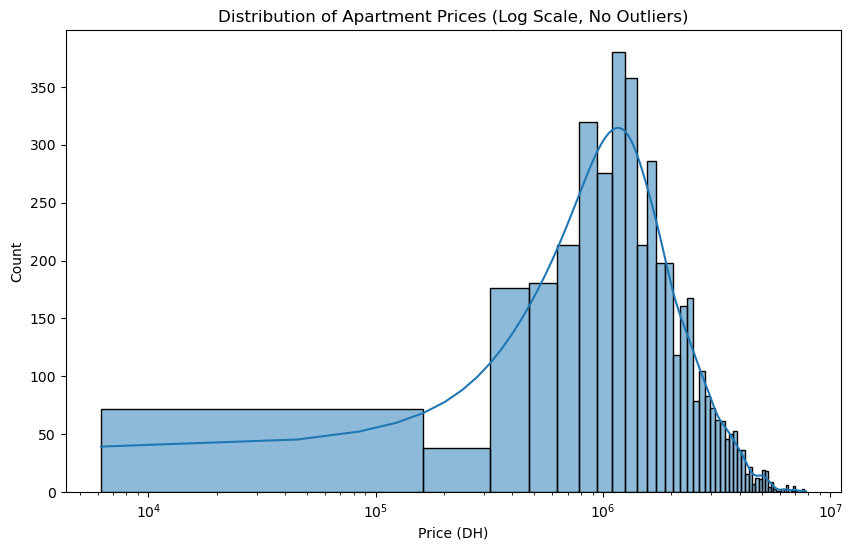

In [110]:
plt.figure(figsize=(10,6))
sns.histplot(df_no_outliers["Price"], bins=50, kde=True)
plt.xscale('log')
plt.title("Distribution of Apartment Prices (Log Scale, No Outliers)")
plt.xlabel("Price (DH)")
plt.ylabel("Count")
plt.show()

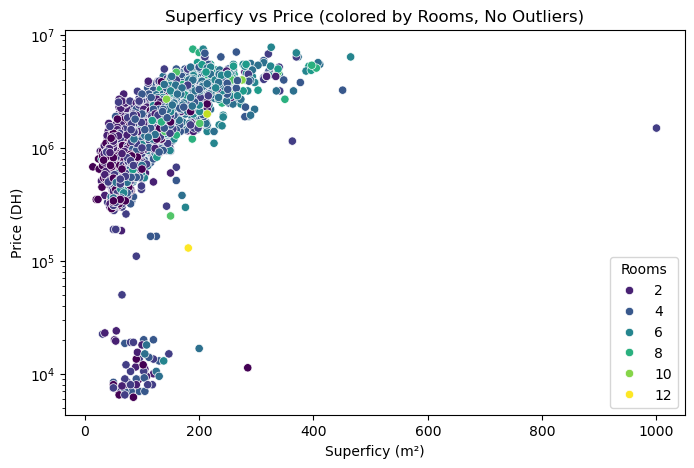

In [111]:
# 5.2 Superficy vs Price scatter
plt.figure(figsize=(8,5))
sns.scatterplot(x="Superficy", y="Price", hue="Rooms", data=df_no_outliers, palette="viridis")
plt.yscale('log')
plt.title("Superficy vs Price (colored by Rooms, No Outliers)")
plt.xlabel("Superficy (m²)")
plt.ylabel("Price (DH)")
plt.show()

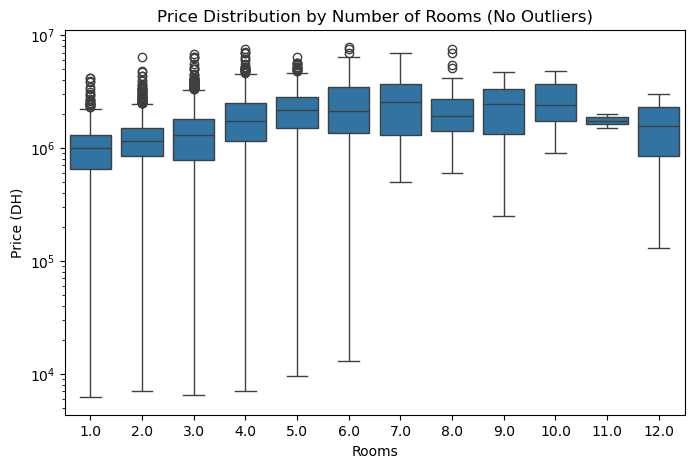

In [112]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Rooms", y="Price", data=df_no_outliers)
plt.yscale('log')
plt.title("Price Distribution by Number of Rooms (No Outliers)")
plt.ylabel("Price (DH)")
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_25184\2366624266.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.values, y=avg_price.index, palette="coolwarm")


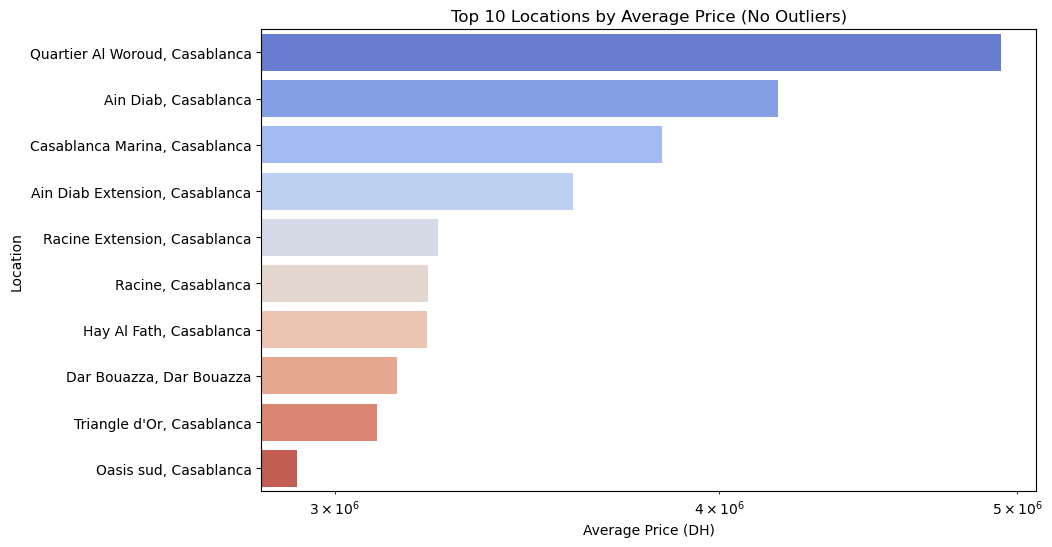

In [113]:
# 5.4 Average Price per Location (Top 10)
plt.figure(figsize=(10,6))

# Compute average price per location and take top 10
avg_price = df_no_outliers.groupby("Location")["Price"].mean().sort_values(ascending=False).head(10)

# Horizontal barplot
sns.barplot(x=avg_price.values, y=avg_price.index, palette="coolwarm")
plt.xscale('log')  # log scale
plt.xlabel("Average Price (DH)")
plt.ylabel("Location")
plt.title("Top 10 Locations by Average Price (No Outliers)")
plt.show()


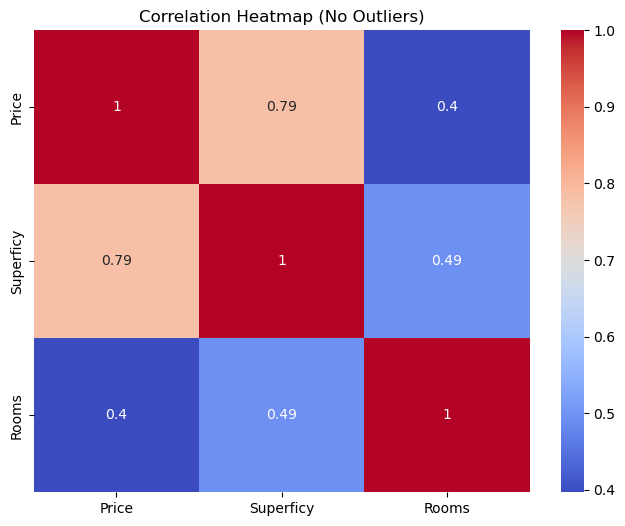

In [114]:
plt.figure(figsize=(8,6))
sns.heatmap(df_no_outliers[["Price", "Superficy", "Rooms"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (No Outliers)")
plt.show()

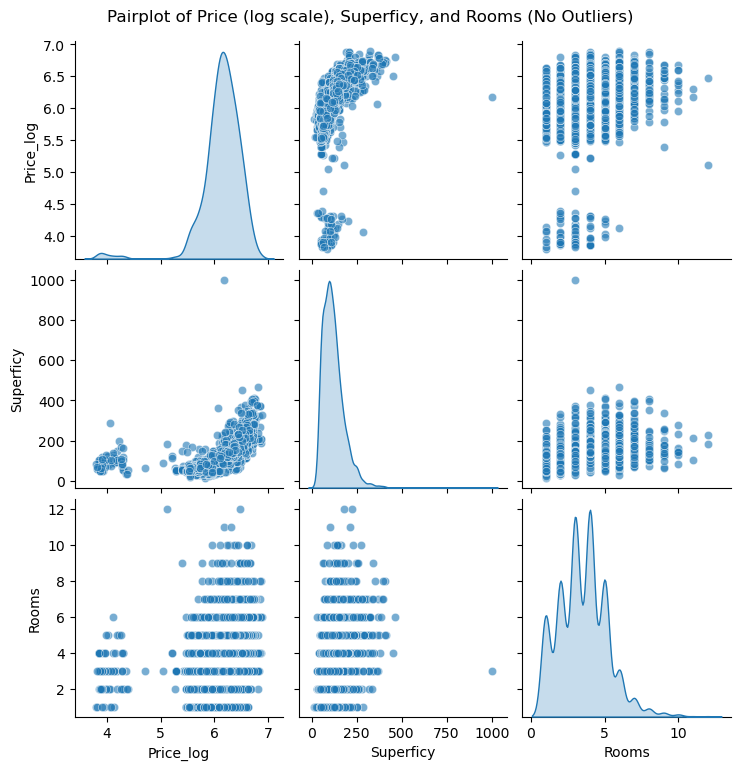

In [115]:
df_pair = df_no_outliers[["Price", "Superficy", "Rooms"]].copy()
df_pair["Price_log"] = np.log10(df_pair["Price"])
sns.pairplot(
    df_pair,
    vars=["Price_log", "Superficy", "Rooms"],
    kind="scatter",
    diag_kind="kde",
    plot_kws={"alpha":0.6}
)
plt.suptitle("Pairplot of Price (log scale), Superficy, and Rooms (No Outliers)", y=1.02)
plt.show()

In [118]:
# Export to Excel
df_no_outliers.to_excel("df_no_outliers.xlsx", index=False)

In [119]:
# Basic info about columns, types, and non-null counts
df_no_outliers.info()

# Descriptive statistics for numeric columns
df_no_outliers.describe()

# Check first few rows
df_no_outliers.head()

# Check for missing values
df_no_outliers.isnull().sum()

# Check the shape (rows, columns)
df_no_outliers.shape

# Optional: get a summary of unique values per column
df_no_outliers.nunique()


<class 'pandas.core.frame.DataFrame'>
Index: 4183 entries, 0 to 4426
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4183 non-null   object 
 1   Location   4183 non-null   object 
 2   Price      4183 non-null   float64
 3   Superficy  4126 non-null   float64
 4   Rooms      3932 non-null   float64
dtypes: float64(3), object(2)
memory usage: 196.1+ KB


Name         3944
Location      178
Price         696
Superficy     291
Rooms          12
dtype: int64

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [121]:
features = ['Location', 'Superficy', 'Rooms']
target = 'Price'

X = df_no_outliers[features].copy()
y = df_no_outliers[target].copy()

# Fill missing numeric values
X['Superficy'] = X['Superficy'].fillna(X['Superficy'].median())
X['Rooms'] = X['Rooms'].fillna(X['Rooms'].median())


numeric_features = ['Superficy', 'Rooms', 'Price']
corr = df_no_outliers[numeric_features].corr()
print("Correlation matrix:\n", corr)

Correlation matrix:
            Superficy     Rooms     Price
Superficy   1.000000  0.494619  0.785498
Rooms       0.494619  1.000000  0.396604
Price       0.785498  0.396604  1.000000


In [123]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Superficy', 'Rooms']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Location'])
    ]
)

In [133]:
from sklearn.model_selection import RandomizedSearchCV
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# -----------------------------
# Hyperparameter grid
# -----------------------------
param_distributions = {
    'regressor__n_estimators': [200, 300, 400, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# -----------------------------
# Randomized Search CV
# -----------------------------
search = RandomizedSearchCV(
    pipeline, param_distributions,
    n_iter=50,  # number of combinations to try
    scoring='r2',  # optimize R²
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the search
search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Superficy',
                                                                                'Rooms']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Location'])])),
                                             ('regressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.2],
                                        'regressor__max_depth': [3, 4, 5, 6],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [200, 300,
                                                                    400, 500],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Superficy', 'Rooms']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Location'])
    ]
)

In [137]:
# 2️⃣ Rebuild pipeline with best hyperparameters
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        learning_rate=0.01,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=4,
        n_estimators=300,
        subsample=1.0,
        random_state=42
    ))
])

In [138]:

# 3️⃣ Train on the full dataset (or train/test split if you want evaluation)
X = df_no_outliers[['Location', 'Superficy', 'Rooms']].copy()
y = df_no_outliers['Price'].copy()

# Fill missing numeric values
X['Superficy'] = X['Superficy'].fillna(X['Superficy'].median())
X['Rooms'] = X['Rooms'].fillna(X['Rooms'].median())

# Optional: train/test split for evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

# 4️⃣ Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")


Test RMSE: 511537.23
Test R²: 0.804


In [139]:
# Create price per square meter
df_no_outliers['Price_per_m2'] = df_no_outliers['Price'] / df_no_outliers['Superficy']

In [140]:
# Create indicator features
df_no_outliers['is_luxury'] = df_no_outliers['Name'].str.contains('luxueux|luxury', case=False, regex=True).astype(int)
df_no_outliers['has_pool'] = df_no_outliers['Name'].str.contains('piscine|pool', case=False, regex=True).astype(int)
df_no_outliers['sea_view'] = df_no_outliers['Name'].str.contains('vue mer|sea view', case=False, regex=True).astype(int)
df_no_outliers['penthouse'] = df_no_outliers['Name'].str.contains('penthouse|pentouhouse', case=False, regex=True).astype(int)

In [141]:
# Compute average price per Location
location_avg = df_no_outliers.groupby('Location')['Price'].transform('mean')
df_no_outliers['Location_avg_price'] = location_avg

In [142]:
features = [
    'Location',
    'Superficy',
    'Rooms',
    'Price_per_m2',
    'is_luxury',
    'has_pool',
    'sea_view',
    'penthouse',
    'Location_avg_price'
]
target = 'Price'

X = df_no_outliers[features].copy()
y = df_no_outliers[target].copy()

# Fill numeric missing values
for col in ['Superficy', 'Rooms', 'Price_per_m2', 'Location_avg_price']:
    X[col] = X[col].fillna(X[col].median())

In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['Superficy', 'Rooms', 'Price_per_m2', 'Location_avg_price', 'is_luxury', 'has_pool', 'sea_view', 'penthouse']
categorical_features = ['Location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        learning_rate=0.01,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=4,
        n_estimators=300,
        subsample=1.0,
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

Test RMSE: 131305.61
Test R²: 0.987


In [145]:
import joblib

# Save the trained pipeline
joblib.dump(model, 'real_estate_model.pkl')
print("Model saved as 'real_estate_model.pkl'")

Model saved as 'real_estate_model.pkl'


In [146]:
# During training
median_location_avg = df_no_outliers['Location_avg_price'].median()

# Save it alongside the model
joblib.dump({'model': model, 'median_location_avg': median_location_avg}, 'real_estate_model_with_median.pkl')


['real_estate_model_with_median.pkl']

In [148]:
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('real_estate_model.pkl')

# Compute median Location_avg_price from training set for fallback
median_location_avg = df_no_outliers['Location_avg_price'].median()

def predict_price(location, superficy, rooms, name=''):
    """
    Predict property price using Location, Superficy, Rooms, Name.
    Location_avg_price is automatically filled from training median.
    """
    # Feature extraction from Name
    is_luxury = int(bool(pd.Series([name]).str.contains('luxueux|luxury', case=False, regex=True)[0]))
    has_pool = int(bool(pd.Series([name]).str.contains('piscine|pool', case=False, regex=True)[0]))
    sea_view = int(bool(pd.Series([name]).str.contains('vue mer|sea view', case=False, regex=True)[0]))
    penthouse = int(bool(pd.Series([name]).str.contains('penthouse|pentouhouse', case=False, regex=True)[0]))
    
    # Price_per_m2 can be 0 as placeholder
    price_per_m2 = 0
    
    # Location_avg_price: average for this location if exists, otherwise fallback to median
    loc_avg = df_no_outliers[df_no_outliers['Location'] == location]['Price'].mean()
    if pd.isna(loc_avg):
        loc_avg = median_location_avg
    
    # Prepare DataFrame for prediction
    df = pd.DataFrame({
        'Location': ['Maârif'],
        'Superficy': [110],
        'Rooms': [2],
        'Price_per_m2': [0],
        'is_luxury': [1],
        'has_pool': [0],
        'sea_view': [0],
        'penthouse': [0],
        'Location_avg_price': [loc_avg]
    })
    
    # Predict
    predicted_price = model.predict(df)
    return predicted_price[0]

# Example usage
predicted = predict_price(location='Oasis', superficy=45, rooms=1, name='Luxueux studio')
print(f"Predicted price: {predicted:.2f} MAD")

Predicted price: 110695.66 MAD
